In [3]:
import sys
sys.path.append("/Users/admin/Desktop/diploma")

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from scipy.optimize import minimize
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import RepeatedKFold
from scipy.optimize import minimize
import numpy.ma as mask
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample, check_random_state

#algos
from runc import RuncDualizer
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from models import BoostingElementaryPredicates, BoostingElementaryPredicatesv2
# from bagging_trees import BaggingElementaryTrees

from tqdm import tqdm
from math import sqrt
import math
import itertools
from sklearn.datasets import load_diabetes
from sklearn.datasets import make_regression
import numpy as np
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed
from own_forest import *
from utilites import *
from own_forest import *
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from memory_profiler import profile
from time import time

# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
#pip install catboost or conda install -c conda-forge catboost (using Anaconda or Miniconda)

In [2]:
import gc

gc.collect()

0

## Вспомогательные функции 

In [4]:
# GRID SEARCH
def hp_tuning(X_train, X_test, y_train, y_test, model, params, dataset_name, model_name):
    scoring_fnc = make_scorer(rmse, greater_is_better=False)
    grid_search = GridSearchCV(estimator=model, param_grid=params, scoring=scoring_fnc, cv=3)
    grid_search = grid_search.fit(X_train, y_train)

    print(f"Best hyperparameters for {model_name} on {dataset_name}: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_

    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
    test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

    print(f"\n--Train RMSE for {model_name} on {dataset_name}--\n{train_rmse}")
    print(f"\n--Test RMSE for {model_name} on {dataset_name}--\n{test_rmse}\n")

    return best_model, train_rmse, test_rmse

In [2]:
# RANDOMIZED SEARCH
def hp_tuning(X_train, X_test, y_train, y_test, model, params, dataset_name, model_name, n_iter=10):
    scoring_fnc = make_scorer(rmse, greater_is_better=False)
    randomized_search = RandomizedSearchCV(estimator=model, param_distributions=params, 
                                           n_iter=n_iter, scoring=scoring_fnc, cv=3, random_state=42)
    randomized_search.fit(X_train, y_train)

    print(f"Best hyperparameters for {model_name} on {dataset_name}: {randomized_search.best_params_}")
    best_model = randomized_search.best_estimator_

    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
    test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    print(f"\n--Train RMSE for {model_name} on {dataset_name}--\n{train_rmse}")
    print(f"--Test RMSE for {model_name} on {dataset_name}--\n{test_rmse}\n")
    print(f"--Train R2 for {model_name} on {dataset_name}--\n{train_r2}")
    print(f"--Test R2 for {model_name} on {dataset_name}--\n{test_r2}\n")

    return best_model, train_rmse, test_rmse, train_r2, test_r2

In [4]:
def visualize_errors(X_train, X_test, y_train, y_test, models, params):
    """
    Отображение изменения качества моделей при изменении гиперпараметров.
    
    Параметры:
    - X_train: обучающий набор признаков
    - X_test: тестовый набор признаков
    - y_train: обучающий набор целевой переменной
    - y_test: тестовый набор целевой переменной
    - models: список кортежей с моделями и их названиями
    - lb_params: словарь с диапазонами гиперпараметров
    """
    for model_name, model_class in models:
        test_results = []
        for num_iter in params["num_iter"]:
            model = model_class(num_iter=num_iter, **params['model_specific_params'])
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            rmse = mean_squared_error(y_test, y_pred, squared=False)
            test_results.append(rmse)
            print(f"{model_name} | Number of iters: {num_iter}, Test RMSE: {rmse}")

        plt.plot(params["num_iter"], test_results, label=model_name)

    plt.title("Test RMSE across different num_iter")
    plt.legend()
    plt.xlabel("num_iter")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [5]:
def visualize_scores(models, dataset, n_splits=10):
    """
    Визуализация боксплотов качества r2-score для различных моделей.
    
    Параметры:
    - models: список моделей с их названиями для сравнения
    - dataset: исходный датасет
    - n_splits: количество независимых запусков и разбиений
    """
    
    scores = {model_name: [] for model_name, _ in models}

    for _ in range(n_splits):
        # Предположим, что функция preprocess уже определена
        X_train, X_test, y_train, y_test = preprocess(dataset, 'TARGET_VARIABLE')
        
        for model_name, model in models:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            scores[model_name].append(r2)

    # Визуализация боксплотов
    scores_df = pd.DataFrame(scores)
    sns.boxplot(data=scores_df)
    plt.ylabel('R2 Score')
    plt.title('Comparison of R2 Scores across Models')
    plt.tight_layout()
    plt.show()

# Эксперименты на реальных данных 


## Датасет Air Quality

In [ ]:
#pip install ucimlrepo

In [5]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
air_quality = fetch_ucirepo(id=360) 
  
# data (as pandas dataframes) 
X = air_quality.data.features 
y = air_quality.data.targets 
  
# metadata 
print(air_quality.metadata) 


{'uci_id': 360, 'name': 'Air Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/360/air+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/360/data.csv', 'abstract': 'Contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer. ', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 9358, 'num_features': 15, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C59K5F', 'creators': ['Saverio Vito'], 'intro_paper': {'title': 'On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario', 'authors': 'S. D. Vito, E. Massera, M. P

In [5]:
air_quality.variables

name     role         type demographic  \
0            Date  Feature         Date        None   
1            Time  Feature  Categorical        None   
2          CO(GT)  Feature      Integer        None   
3     PT08.S1(CO)  Feature  Categorical        None   
4        NMHC(GT)  Feature      Integer        None   
5        C6H6(GT)  Feature   Continuous        None   
6   PT08.S2(NMHC)  Feature  Categorical        None   
7         NOx(GT)  Feature      Integer        None   
8    PT08.S3(NOx)  Feature  Categorical        None   
9         NO2(GT)  Feature      Integer        None   
10   PT08.S4(NO2)  Feature  Categorical        None   
11    PT08.S5(O3)  Feature  Categorical        None   
12              T  Feature   Continuous        None   
13             RH  Feature   Continuous        None   
14             AH  Feature   Continuous        None   

                                          description       units  \
0                                                None        None   
1                                                None        None   
2   True hourly averaged concentration CO in mg/m^...      mg/m^3   
3   hourly averaged sensor response (nominally  CO...        None   
4   True hourly averaged overall Non Metanic Hydro...  microg/m^3   
5   True hourly averaged Benzene concentration  in...  microg/m^3   
6   hourly averaged sensor response (nominally NMH...        None   
7   True hourly averaged NOx concentration  in ppb...         ppb   
8   hourly averaged sensor response (nominally NOx...        None   
9   True hourly averaged NO2 concentration in micr...  microg/m^3   
10  hourly averaged sensor response (nominally NO2...        None   
11  hourly averaged sensor response (nominally O3 ...        None   
12                                        Temperature          °C   
13                                  Relative Humidity           %   
14                                  Absolute Humidity        None   

   missing_values  
0              no  
1              no  
2              no  
3              no  
4              no  
5              no  
6              no  
7              no  
8              no  
9              no  
10             no  
11             no  
12             no  
13             no  
14             no

In [7]:
# url = 'https://archive.ics.uci.edu/static/public/360/data.csv'
# column_names = ['Time', 'CO(GT)','PT08.S1(CO)', 'NMHC(GT)','C6H6(GT)','PT08.S2(NMHC)',
#                 'NOx(GT)','PT08.S3(NOx)','NO2(GT)','PT08.S4(NO2)','PT08.S5(O3)','T','RH','AH']

# dataset = pd.read_csv(url, skiprows=1, names=column_names,
#                           na_values='?', comment='\t',
#                           sep=',', skipinitialspace=True)


In [6]:
# Преобразование столбца Time из строкового формата в количество минут
# X['Time'] = X['Time'].apply(lambda x: sum(int(a) * 60 for a in reversed(x.split(':'))))

In [9]:
X.head()

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  3/10/2004  18:00:00     2.6         1360       150      11.9   
1  3/10/2004  19:00:00     2.0         1292       112       9.4   
2  3/10/2004  20:00:00     2.2         1402        88       9.0   
3  3/10/2004  21:00:00     2.2         1376        80       9.2   
4  3/10/2004  22:00:00     1.6         1272        51       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0           1046      166          1056      113          1692         1268   
1            955      103          1174       92          1559          972   
2            939      131          1140      114          1555         1074   
3            948      172          1092      122          1584         1203   
4            836      131          1205      116          1490         1110   

      T    RH      AH  
0  13.6  48.9  0.7578  
1  13.3  47.7  0.7255  
2  11.9  54.0  0.7502  
3  11.0  60.0  0.7867  
4  11.2  59.6  0.7888

In [6]:
X['Date'] = pd.to_datetime(X['Date'], format='%m/%d/%Y')
X['Month']= X['Date'].dt.month  
X['Hour']=X['Time'].apply(lambda x: int(x.split(':')[0]))

In [7]:
X = X.drop(['Date', 'Time'], axis=1)
X.head()

CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0     2.6         1360       150      11.9           1046      166   
1     2.0         1292       112       9.4            955      103   
2     2.2         1402        88       9.0            939      131   
3     2.2         1376        80       9.2            948      172   
4     1.6         1272        51       6.5            836      131   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  \
0          1056      113          1692         1268  13.6  48.9  0.7578   
1          1174       92          1559          972  13.3  47.7  0.7255   
2          1140      114          1555         1074  11.9  54.0  0.7502   
3          1092      122          1584         1203  11.0  60.0  0.7867   
4          1205      116          1490         1110  11.2  59.6  0.7888   

   Month  Hour  
0      3    18  
1      3    19  
2      3    20  
3      3    21  
4      3    22

In [8]:
X.shape

(9357, 15)

In [9]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocess(X, 'RH')

In [10]:
X_train.shape

(7485, 14)

Будем использовать в качестве сравнения с моделью 3 различных реализации градиентного бустинга: LightGBM, Catboost и GBRegressor (from sklearn).

In [10]:
import logging

dataset_name = 'Air Quality'

# lb_params =  {
#     "num_iter" : np.linspace(1, 100, 10).astype(int),
#     "m" : np.linspace(10, 20, 5).astype(int),
#     "max_cov": [100, 500]
# }

lgbm_params = {
    'num_leaves': [x for x in range(2, 32, 8)], 
    'max_depth': [x for x in range(3, 7)],
    'learning_rate': [0.1]
}

cb_params = {
    'depth': [x for x in range(3, 10)], 
    'learning_rate': [0.1],
    'grow_policy': ['SymmetricTree', 'Depthwise'], 
    'score_function': ['Cosine', 'L2']
}

gb_params = {
    'n_estimators': [50, 100, 150], 
    'max_depth': [3, 5, 7]
}

models = [
    # ("BoostingElementaryPredicates", BoostingElementaryPredicatesv2(max_cov=500), lb_params),
    ("LightGBM", LGBMRegressor(num_threads=1, verbose=-1), lgbm_params),
    ("CatBoost", CatBoostRegressor(thread_count=1), cb_params),
    ("GBRegressor", GradientBoostingRegressor(), gb_params)
]

results = []

# for model_name, model, params in models:
#     _, train_rmse, test_rmse = hp_tuning(X_train, X_test, y_train, y_test, model, params, dataset_name, model_name)
#     results.append((dataset_name, model_name, train_rmse, test_rmse))
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

for model_name, model, params in models:
    logging.info(f"Starting training for model {model_name}")
    try:
        _, train_rmse, test_rmse = hp_tuning(X_train, X_test, y_train, y_test, model, params, dataset_name, model_name)
        results.append((dataset_name, model_name, train_rmse, test_rmse))
        logging.info(f"Finished training for model {model_name} successfully")
    except Exception as e:
        logging.error(f"Error training model {model_name}: {e}")
        continue
# Представление результатов
results_df = pd.DataFrame(results, columns=['Dataset', 'Model', 'Train RMSE', 'Test RMSE'])
print(results_df)

2024-05-01 15:22:15,395 - INFO - Starting training for model LightGBM


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2808
[LightGBM] [Info] Number of data points in the train set: 4990, number of used features: 14
[LightGBM] [Info] Start training from score 39.443607
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2835
[LightGBM] [Info] Number of data points in the train set: 4990, number of used features: 14
[LightGBM] [Info] Start training from score 39.764709
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2827
[LightGBM] [Info] Number of data points in the train set

2024-05-01 15:22:20,697 - INFO - Finished training for model LightGBM successfully
2024-05-01 15:22:20,697 - INFO - Starting training for model CatBoost



--Train RMSE for LightGBM on Air Quality--
0.7153323400900471

--Test RMSE for LightGBM on Air Quality--
0.8780731685542948

0:	learn: 47.3539798	total: 74.9ms	remaining: 1m 14s
1:	learn: 43.3415879	total: 76.7ms	remaining: 38.3s
2:	learn: 39.7474361	total: 78.2ms	remaining: 26s
3:	learn: 36.3458935	total: 79.6ms	remaining: 19.8s
4:	learn: 33.5315121	total: 81ms	remaining: 16.1s
5:	learn: 30.7131353	total: 82.8ms	remaining: 13.7s
6:	learn: 28.3621285	total: 84.1ms	remaining: 11.9s
7:	learn: 26.2456365	total: 85.5ms	remaining: 10.6s
8:	learn: 24.2343025	total: 86.9ms	remaining: 9.56s
9:	learn: 22.4443661	total: 88.4ms	remaining: 8.76s
10:	learn: 20.9468299	total: 90.3ms	remaining: 8.12s
11:	learn: 19.5517570	total: 91.8ms	remaining: 7.55s
12:	learn: 18.4349747	total: 93.2ms	remaining: 7.08s
13:	learn: 17.4130303	total: 94.5ms	remaining: 6.66s
14:	learn: 16.5691627	total: 95.9ms	remaining: 6.3s
15:	learn: 15.7696037	total: 97.6ms	remaining: 6s
16:	learn: 14.9461767	total: 99.1ms	remaini

2024-05-01 16:04:26,563 - INFO - Finished training for model CatBoost successfully


998:	learn: 0.2387857	total: 16.7s	remaining: 16.8ms
999:	learn: 0.2385717	total: 16.8s	remaining: 0us
Best hyperparameters for CatBoost on Air Quality: {'depth': 7, 'grow_policy': 'SymmetricTree', 'learning_rate': 0.1, 'score_function': 'L2'}

--Train RMSE for CatBoost on Air Quality--
0.23857170925912266

--Test RMSE for CatBoost on Air Quality--
0.4420007169843906



2024-05-01 16:04:26,607 - INFO - Starting training for model GBRegressor
2024-05-01 16:05:59,396 - INFO - Finished training for model GBRegressor successfully


Best hyperparameters for GBRegressor on Air Quality: {'max_depth': 7, 'n_estimators': 150}

--Train RMSE for GBRegressor on Air Quality--
0.3323703523330495

--Test RMSE for GBRegressor on Air Quality--
0.6222969359244813

       Dataset        Model  Train RMSE  Test RMSE
0  Air Quality     LightGBM    0.715332   0.878073
1  Air Quality     CatBoost    0.238572   0.442001
2  Air Quality  GBRegressor    0.332370   0.622297


In [11]:
results_df

Dataset        Model  Train RMSE  Test RMSE
0  Air Quality     LightGBM    0.715332   0.878073
1  Air Quality     CatBoost    0.238572   0.442001
2  Air Quality  GBRegressor    0.332370   0.622297

## Датасет NeorChem Prediction

Признаки слитка


        
      NPLAV - номер сертификата ститка. По этому идентификатору можно связать, какие детали были сделаны из одного слитка.

        
      MASS - масса слитка

        
      DIAMETER - диаметр слитка

        
      MASS_STRUG, N_MASS_STRUG - какие-то характеристики слитка (не знаю какие). Надо проверить, что они фиксированы для одинаковых NPLAV

        
      HIM_NAME_STR - список названий хим.элементов в слитке. Например, Al1 - аллюминий сверху, Al2 - аллюминий снизу.

        
      EL_ZN_STR - список значений хим. состава слитка, соответсвующий списку HIM_NAME_STR


Признаки изделия


        
      SOOTV_ID - ?????

        
      MFG_ORDER_ID - некий идентификатор заказа

        
      N_OBR - номер тестируемого образца

        
      NC_ZAK - номер заказа (по-моему, везде одинаковый)

        
      POS_KRAT - позиция в крате. Слиток распиливается на краты. Из крат вырезают заготовки. Каждой заготовке прискаивается номер

        
      KRATA - номер краты в слитке (оказалось, что форма зависимости от KRATA наших таргетов достаточно интересная - надо перепроверить)


Целевые переменные (мех. свойства детали)


        
      PRED_TEK_USL -пределел текучести условный, ksi

        
      VR_SOPR - временное сопротивление, ksi

        
      OTN_UDL - относительное удлинение, %

        
      OTN_SUZ - относительное сужение, %

In [14]:
# cd /Users/admin/Desktop/diploma

In [15]:
data = pd.read_csv("neor_him_meh.csv")
data

NPLAV    MASS  DIAMETER  MASS_STRUG  N_MASS_STRUG  \
0     0-08-03401  2184.0     650.0         0.0         908.2   
1     0-08-03401  2184.0     650.0         0.0         908.2   
2     0-08-03401  2184.0     650.0         0.0         908.2   
3     0-08-03401  2184.0     650.0         0.0         908.2   
4     0-08-03401  2184.0     650.0         0.0         908.2   
...          ...     ...       ...         ...           ...   
4831  8-47-01272  4190.0     744.0         0.0        1788.8   
4832  8-47-01272  4190.0     744.0         0.0        1788.8   
4833  8-47-01272  4190.0     744.0         0.0        1788.8   
4834  8-47-01272  4190.0     744.0         0.0        1788.8   
4835  8-47-01272  4190.0     744.0         0.0        1788.8   

                                           HIM_NAME_STR  \
0     Al1;Al2;Fe1;Fe2;H1;H2;N1;N2;O1;O2;C1;C2;V1;V2;...   
1     Al1;Al2;Fe1;Fe2;H1;H2;N1;N2;O1;O2;C1;C2;V1;V2;...   
2     Al1;Al2;Fe1;Fe2;H1;H2;N1;N2;O1;O2;C1;C2;V1;V2;...   
3     Al1;Al2;Fe1;Fe2;H1;H2;N1;N2;O1;O2;C1;C2;V1;V2;...   
4     Al1;Al2;Fe1;Fe2;H1;H2;N1;N2;O1;O2;C1;C2;V1;V2;...   
...                                                 ...   
4831  Al1;Al2;Fe1;Fe2;H1;H2;N1;N2;O1;O2;C1;C2;V1;V2;...   
4832  Al1;Al2;Fe1;Fe2;H1;H2;N1;N2;O1;O2;C1;C2;V1;V2;...   
4833  Al1;Al2;Fe1;Fe2;H1;H2;N1;N2;O1;O2;C1;C2;V1;V2;...   
4834  Al1;Al2;Fe1;Fe2;H1;H2;N1;N2;O1;O2;C1;C2;V1;V2;...   
4835  Al1;Al2;Fe1;Fe2;H1;H2;N1;N2;O1;O2;C1;C2;V1;V2;...   

                                              EL_ZN_STR  PRED_TEK_USL  \
0     6.08;6.19;0.20;0.20;0.005;0.005;0.024;0.020;0....         908.0   
1     6.08;6.19;0.20;0.20;0.005;0.005;0.024;0.020;0....         897.0   
2     6.08;6.19;0.20;0.20;0.005;0.005;0.024;0.020;0....         884.0   
3     6.08;6.19;0.20;0.20;0.005;0.005;0.024;0.020;0....         891.0   
4     6.08;6.19;0.20;0.20;0.005;0.005;0.024;0.020;0....         885.0   
...                                                 ...           ...   
4831  6.48;6.52;0.21;0.18;0.0005;0.0007;0.013;0.013;...         887.0   
4832  6.48;6.52;0.21;0.18;0.0005;0.0007;0.013;0.013;...         899.0   
4833  6.48;6.52;0.21;0.18;0.0005;0.0007;0.013;0.013;...         909.0   
4834  6.48;6.52;0.21;0.18;0.0005;0.0007;0.013;0.013;...         894.0   
4835  6.48;6.52;0.21;0.18;0.0005;0.0007;0.013;0.013;...         905.0   

      VR_SOPR  OTN_UDL  OTN_SUZ  SOOTV_ID          MFG_ORDER_ID  \
0      1007.0     18.3     41.9         1  НЕ ПЛАНИРУЕТСЯ В LPP   
1       988.0     17.9     41.0         1  НЕ ПЛАНИРУЕТСЯ В LPP   
2       978.0     17.5     41.8         1  НЕ ПЛАНИРУЕТСЯ В LPP   
3       990.0     17.5     40.6         1  НЕ ПЛАНИРУЕТСЯ В LPP   
4       984.0     17.9     41.8         1  НЕ ПЛАНИРУЕТСЯ В LPP   
...       ...      ...      ...       ...                   ...   
4831    980.0     17.9     44.6         1         04-0736882-19   
4832    994.0     17.9     42.5         1         04-0736882-19   
4833   1004.0     15.8     38.3         1         04-0736882-19   
4834    991.0     16.7     39.7         1         04-0736882-19   
4835    999.0     16.7     40.1         1         04-0736882-19   

                    N_OBR  NC_ZAK  POS_KRAT KRATA  
0     VS5953  (NO.5) FL 1       4         1     1  
1            VS5953  FL 2       4         1     1  
2            VS5954  FL 2       4         2     1  
3            VS5955  FL 2       4         3     1  
4            VS5956  FL 2       4         4     1  
...                   ...     ...       ...   ...  
4831          VS9185 FL 2       4         5     6  
4832          VS9186 FL 2       4         6     6  
4833          VS9187 FL 2       4         7     6  
4834          VS9188 FL 2       4         8     6  
4835          VS9189 FL 2       4         9     6  

[4836 rows x 17 columns]

In [16]:
# предобработка данных
unique_him_names = data['HIM_NAME_STR'].unique()

# Разбиение столбца EL_ZN_STR на столбцы с именами из HIM_NAME_STR
for i, him_name in enumerate(unique_him_names):
    data[f"HIM_NAME_{i+1}"] = data['EL_ZN_STR'].apply(lambda x: x.split()[unique_him_names.tolist().index(him_name)] if len(x.split()) > unique_him_names.tolist().index(him_name) else None)
unique_him_names

array(['Al1;Al2;Fe1;Fe2;H1;H2;N1;N2;O1;O2;C1;C2;V1;V2;Y1;Y2;ПК1;ПК2;ПС1;ПС2'],
      dtype=object)

In [17]:
data.dtypes

NPLAV            object
MASS            float64
DIAMETER        float64
MASS_STRUG      float64
N_MASS_STRUG    float64
HIM_NAME_STR     object
EL_ZN_STR        object
PRED_TEK_USL    float64
VR_SOPR         float64
OTN_UDL         float64
OTN_SUZ         float64
SOOTV_ID          int64
MFG_ORDER_ID     object
N_OBR            object
NC_ZAK            int64
POS_KRAT          int64
KRATA            object
HIM_NAME_1       object
dtype: object

In [18]:
X_train, X_test, y_train, y_test = preprocess(data, 'VR_SOPR')

AttributeError: 'DataFrame' object has no attribute 'data'

# Датасет Automobile

In [3]:
from ucimlrepo import fetch_ucirepo
automobile = fetch_ucirepo(id=10) 
  
# data (as pandas dataframes) 
X = automobile.data.features 
y = automobile.data.targets 
  
# metadata 
print(automobile.metadata) 
  
# variable information 
print(automobile.variables) 

{'uci_id': 10, 'name': 'Automobile', 'repository_url': 'https://archive.ics.uci.edu/dataset/10/automobile', 'data_url': 'https://archive.ics.uci.edu/static/public/10/data.csv', 'abstract': "From 1985 Ward's Automotive Yearbook", 'area': 'Other', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 205, 'num_features': 25, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['symboling'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1985, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5B01C', 'creators': ['Jeffrey Schlimmer'], 'intro_paper': None, 'additional_info': {'summary': 'This data set consists of three types of entities: (a) the specification of an auto in terms of various characteristics, (b) its assigned insurance risk rating, (c) its normalized losses in use as compared to other cars.  The second rating corresponds to the degree to which th

In [4]:
X.isna().sum()

price                 4
highway-mpg           0
city-mpg              0
peak-rpm              2
horsepower            2
compression-ratio     0
stroke                4
bore                  4
fuel-system           0
engine-size           0
num-of-cylinders      0
engine-type           0
curb-weight           0
height                0
width                 0
length                0
wheel-base            0
engine-location       0
drive-wheels          0
body-style            0
num-of-doors          2
aspiration            0
fuel-type             0
make                  0
normalized-losses    41
dtype: int64

In [4]:
X = X[~X['price'].isna()].reset_index()
X

index    price  highway-mpg  city-mpg  peak-rpm  horsepower  \
0        0  13495.0           27        21    5000.0       111.0   
1        1  16500.0           27        21    5000.0       111.0   
2        2  16500.0           26        19    5000.0       154.0   
3        3  13950.0           30        24    5500.0       102.0   
4        4  17450.0           22        18    5500.0       115.0   
..     ...      ...          ...       ...       ...         ...   
196    200  16845.0           28        23    5400.0       114.0   
197    201  19045.0           25        19    5300.0       160.0   
198    202  21485.0           23        18    5500.0       134.0   
199    203  22470.0           27        26    4800.0       106.0   
200    204  22625.0           25        19    5400.0       114.0   

     compression-ratio  stroke  bore fuel-system  ...  length  wheel-base  \
0                  9.0    2.68  3.47        mpfi  ...   168.8        88.6   
1                  9.0    2.68  3.47        mpfi  ...   168.8        88.6   
2                  9.0    3.47  2.68        mpfi  ...   171.2        94.5   
3                 10.0    3.40  3.19        mpfi  ...   176.6        99.8   
4                  8.0    3.40  3.19        mpfi  ...   176.6        99.4   
..                 ...     ...   ...         ...  ...     ...         ...   
196                9.5    3.15  3.78        mpfi  ...   188.8       109.1   
197                8.7    3.15  3.78        mpfi  ...   188.8       109.1   
198                8.8    2.87  3.58        mpfi  ...   188.8       109.1   
199               23.0    3.40  3.01         idi  ...   188.8       109.1   
200                9.5    3.15  3.78        mpfi  ...   188.8       109.1   

    engine-location  drive-wheels   body-style  num-of-doors  aspiration  \
0             front           rwd  convertible           2.0         std   
1             front           rwd  convertible           2.0         std   
2             front           rwd    hatchback           2.0         std   
3             front           fwd        sedan           4.0         std   
4             front           4wd        sedan           4.0         std   
..              ...           ...          ...           ...         ...   
196           front           rwd        sedan           4.0         std   
197           front           rwd        sedan           4.0       turbo   
198           front           rwd        sedan           4.0         std   
199           front           rwd        sedan           4.0       turbo   
200           front           rwd        sedan           4.0       turbo   

     fuel-type         make normalized-losses  
0          gas  alfa-romero               NaN  
1          gas  alfa-romero               NaN  
2          gas  alfa-romero               NaN  
3          gas         audi             164.0  
4          gas         audi             164.0  
..         ...          ...               ...  
196        gas        volvo              95.0  
197        gas        volvo              95.0  
198        gas        volvo              95.0  
199     diesel        volvo              95.0  
200        gas        volvo              95.0  

[201 rows x 26 columns]

In [14]:
def preprocess(data, target_name, drop=True, index_col=None):
    if isinstance(data, (str, )):
        if index_col is not None:
            df = pd.read_csv(data, index_col=index_col).reset_index()
        else:
            df = pd.read_csv(data)

    else:
        df = data.copy()
    
    if drop:
        df = df.drop(columns='index')

    # Splitting the dataset into features and target
    X_raw = df.drop(columns=[target_name])
    
    y = df[target_name].to_numpy()
    # y = df[target_name]

    # Normalizing numerical features
    numeric_cols = X_raw.select_dtypes(include=['number']).columns
    scaler = StandardScaler()
    X_raw[numeric_cols] = scaler.fit_transform(X_raw[numeric_cols])

    # Encoding categorical variables
    X_raw = pd.get_dummies(X_raw, drop_first=True)

    # Splitting data into training, validation, and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_raw, y, train_size=0.8, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=0.5, random_state=42)

    return X_train.to_numpy(), X_val.to_numpy(), X_test.to_numpy(), y_train, y_val, y_test

In [15]:
X

index    price  highway-mpg  city-mpg  peak-rpm  horsepower  \
0        0  13495.0           27        21    5000.0       111.0   
1        1  16500.0           27        21    5000.0       111.0   
2        2  16500.0           26        19    5000.0       154.0   
3        3  13950.0           30        24    5500.0       102.0   
4        4  17450.0           22        18    5500.0       115.0   
..     ...      ...          ...       ...       ...         ...   
196    200  16845.0           28        23    5400.0       114.0   
197    201  19045.0           25        19    5300.0       160.0   
198    202  21485.0           23        18    5500.0       134.0   
199    203  22470.0           27        26    4800.0       106.0   
200    204  22625.0           25        19    5400.0       114.0   

     compression-ratio  stroke  bore fuel-system  ...  length  wheel-base  \
0                  9.0    2.68  3.47        mpfi  ...   168.8        88.6   
1                  9.0    2.68  3.47        mpfi  ...   168.8        88.6   
2                  9.0    3.47  2.68        mpfi  ...   171.2        94.5   
3                 10.0    3.40  3.19        mpfi  ...   176.6        99.8   
4                  8.0    3.40  3.19        mpfi  ...   176.6        99.4   
..                 ...     ...   ...         ...  ...     ...         ...   
196                9.5    3.15  3.78        mpfi  ...   188.8       109.1   
197                8.7    3.15  3.78        mpfi  ...   188.8       109.1   
198                8.8    2.87  3.58        mpfi  ...   188.8       109.1   
199               23.0    3.40  3.01         idi  ...   188.8       109.1   
200                9.5    3.15  3.78        mpfi  ...   188.8       109.1   

    engine-location  drive-wheels   body-style  num-of-doors  aspiration  \
0             front           rwd  convertible           2.0         std   
1             front           rwd  convertible           2.0         std   
2             front           rwd    hatchback           2.0         std   
3             front           fwd        sedan           4.0         std   
4             front           4wd        sedan           4.0         std   
..              ...           ...          ...           ...         ...   
196           front           rwd        sedan           4.0         std   
197           front           rwd        sedan           4.0       turbo   
198           front           rwd        sedan           4.0         std   
199           front           rwd        sedan           4.0       turbo   
200           front           rwd        sedan           4.0       turbo   

     fuel-type         make normalized-losses  
0          gas  alfa-romero               NaN  
1          gas  alfa-romero               NaN  
2          gas  alfa-romero               NaN  
3          gas         audi             164.0  
4          gas         audi             164.0  
..         ...          ...               ...  
196        gas        volvo              95.0  
197        gas        volvo              95.0  
198        gas        volvo              95.0  
199     diesel        volvo              95.0  
200        gas        volvo              95.0  

[201 rows x 26 columns]

In [16]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocess(X, 'price')

In [24]:
columns_with_missing = ['peak-rpm', 'horsepower', 'stroke', 'bore', 'num-of-doors', 'normalized-losses']
for column in columns_with_missing:
    X_train[column].fillna(-100, inplace=True)

In [1]:
dataset_name = 'Automobile'

lb_params =  {
    "num_iter" : np.linspace(1, 100, 10).astype(int),
    "m" : np.linspace(10, 20, 5).astype(int),
    "max_cov": [100, 500]
}

lgbm_params = {
    'num_leaves': [x for x in range(2, 32, 8)], 
    'max_depth': [x for x in range(3, 7)],
    'learning_rate': [0.1]
}

cb_params = {
    'depth': [x for x in range(3, 10)], 
    'learning_rate': [0.1],
    'grow_policy': ['SymmetricTree', 'Depthwise'], 
    'score_function': ['Cosine', 'L2']
}

gb_params = {
    'n_estimators': [50, 100, 150], 
    'max_depth': [3, 5, 7]
}

models = [
    # ("BoostingElementaryPredicates", BoostingElementaryPredicatesv2(max_cov=500), lb_params),
    ("LightGBM", LGBMRegressor(verbose=-1), lgbm_params),
    ("CatBoost", CatBoostRegressor(), cb_params),
    ("GBRegressor", GradientBoostingRegressor(), gb_params)
]

results = []

for model_name, model, params in models:
    _, train_rmse, test_rmse, train_r2, test_r2 = hp_tuning(X_train, X_test, y_train, y_test, model, params, dataset_name, model_name)
    results.append((dataset_name, model_name, train_rmse, test_rmse, train_r2, test_r2))

results_df = pd.DataFrame(results, columns=['Dataset', 'Model', 'Train RMSE', 'Test RMSE', 'Train R2', 'Test R2'])
print(results_df)

NameError: name 'np' is not defined

In [3]:
X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)
X_raw.head()
X_raw = X_raw[~X_raw[25].isna()].reset_index()

In [4]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

In [5]:
X_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   201 non-null    int64  
 1   0       201 non-null    int64  
 2   1       164 non-null    float64
 3   2       201 non-null    object 
 4   3       201 non-null    object 
 5   4       201 non-null    object 
 6   5       199 non-null    object 
 7   6       201 non-null    object 
 8   7       201 non-null    object 
 9   8       201 non-null    object 
 10  9       201 non-null    float64
 11  10      201 non-null    float64
 12  11      201 non-null    float64
 13  12      201 non-null    float64
 14  13      201 non-null    int64  
 15  14      201 non-null    object 
 16  15      201 non-null    object 
 17  16      201 non-null    int64  
 18  17      201 non-null    object 
 19  18      197 non-null    float64
 20  19      197 non-null    float64
 21  20      201 non-null    float64
 22  21

In [6]:
X_raw.head()

index  0      1            2    3    4     5            6    7      8  ...  \
0      0  3    NaN  alfa-romero  gas  std   two  convertible  rwd  front  ...   
1      1  3    NaN  alfa-romero  gas  std   two  convertible  rwd  front  ...   
2      2  1    NaN  alfa-romero  gas  std   two    hatchback  rwd  front  ...   
3      3  2  164.0         audi  gas  std  four        sedan  fwd  front  ...   
4      4  2  164.0         audi  gas  std  four        sedan  4wd  front  ...   

     15   16    17    18    19    20     21      22  23  24  
0  four  130  mpfi  3.47  2.68   9.0  111.0  5000.0  21  27  
1  four  130  mpfi  3.47  2.68   9.0  111.0  5000.0  21  27  
2   six  152  mpfi  2.68  3.47   9.0  154.0  5000.0  19  26  
3  four  109  mpfi  3.19  3.40  10.0  102.0  5500.0  24  30  
4  five  136  mpfi  3.19  3.40   8.0  115.0  5500.0  18  22  

[5 rows x 26 columns]

In [7]:
X_raw.isna().sum() # удалим пропуски по столбцам 5, 18, 19, 21, 22, так как их очень мало
# но сначала заполним пропуски в столбце 1 

index     0
0         0
1        37
2         0
3         0
4         0
5         2
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        4
19        4
20        0
21        2
22        2
23        0
24        0
dtype: int64

In [8]:
print(f'Среднее: {X_raw[1].mean()}')
print(f'Мода: {X_raw[1].mode()}')
print(f'медиана: {X_raw[1].median()}')

Среднее: 122.0
Мода: 0    161.0
Name: 1, dtype: float64
медиана: 115.0


/var/folders/6n/8jjs7_ks1vvgsv0l2n5mxvdw0000gn/T/ipykernel_15907/2499893046.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_raw[1], color='#380282', bins=30)


Text(0.5, 1.0, 'Распределение значений переменной 1')

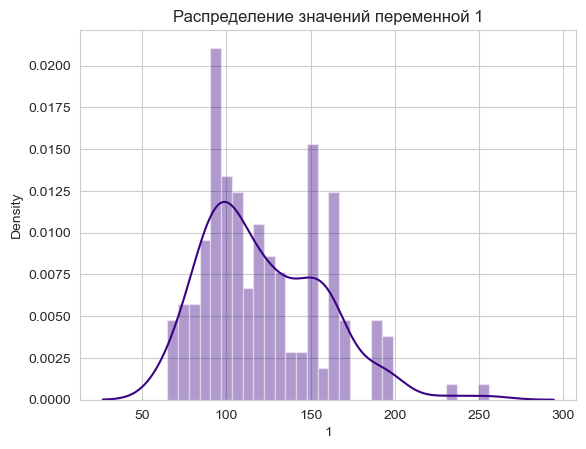

In [9]:
import seaborn as sns
sns.set_style("whitegrid")

sns.distplot(X_raw[1], color='#380282', bins=30)
plt.title('Распределение значений переменной 1') # оптимальное значения для заполнения пропусков - медиана, так как модальной и среднее значения, в данном случае, близки к выбросам

In [10]:
med = X_raw[1].median()

X_raw[1] = X_raw[1].fillna(med)
X_raw.isna().sum() # теперь удаляем остальные пропуски 

index    0
0        0
1        0
2        0
3        0
4        0
5        2
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       4
19       4
20       0
21       2
22       2
23       0
24       0
dtype: int64

In [11]:
X_raw = X_raw.dropna()
X_raw.isna().sum().sum() # порпусков нет

0

In [12]:
# теперь удаляем из y те строки, которые удалили из X_raw
indexes = X_raw.index
y = y[indexes]
y.shape

(193,)

In [13]:
X_raw = X_raw.drop('index', axis=1)

In [16]:
normalizer = StandardScaler()

# отделяем вещественные переменные 
numeric_bool_cols = X_raw.select_dtypes(include=['number']).columns
X_raw[numeric_bool_cols] = normalizer.fit_transform(X_raw[numeric_bool_cols])
X_raw.head()

0         1            2    3    4     5            6    7      8   \
0  1.78685 -0.156202  alfa-romero  gas  std   two  convertible  rwd  front   
1  1.78685 -0.156202  alfa-romero  gas  std   two  convertible  rwd  front   
2  0.16397 -0.156202  alfa-romero  gas  std   two    hatchback  rwd  front   
3  0.97541  1.358876         audi  gas  std  four        sedan  fwd  front   
4  0.97541  1.358876         audi  gas  std  four        sedan  4wd  front   

         9   ...    15        16    17        18        19        20  \
0 -1.682379  ...  four  0.045215  mpfi  0.513027 -1.808186 -0.288273   
1 -1.682379  ...  four  0.045215  mpfi  0.513027 -1.808186 -0.288273   
2 -0.720911  ...   six  0.575559  mpfi -2.394827  0.702918 -0.288273   
3  0.142781  ...  four -0.461021  mpfi -0.517605  0.480415 -0.036204   
4  0.077596  ...  five  0.189854  mpfi -0.517605  0.480415 -0.540341   

         21        22        23        24  
0  0.198569 -0.213359 -0.679053 -0.557058  
1  0.198569 -0.213359 -0.679053 -0.557058  
2  1.334283 -0.213359 -0.992963 -0.704134  
3 -0.039139  0.856208 -0.208189 -0.115832  
4  0.304217  0.856208 -1.149918 -1.292436  

[5 rows x 25 columns]

In [17]:
X_raw = pd.get_dummies(X_raw, drop_first=True)
X_raw.head()

0         1         9        10        11        12        13  \
0  1.78685 -0.156202 -1.682379 -0.444024 -0.841263 -2.122598 -0.025713   
1  1.78685 -0.156202 -1.682379 -0.444024 -0.841263 -2.122598 -0.025713   
2  0.16397 -0.156202 -0.720911 -0.251195 -0.184679 -0.615412  0.497764   
3  0.97541  1.358876  0.142781  0.182672  0.143612  0.180047 -0.427362   
4  0.97541  1.358876  0.077596  0.182672  0.237410  0.180047  0.499668   

         16        18        19  ...  15_four  15_six  15_three  15_twelve  \
0  0.045215  0.513027 -1.808186  ...     True   False     False      False   
1  0.045215  0.513027 -1.808186  ...     True   False     False      False   
2  0.575559 -2.394827  0.702918  ...    False    True     False      False   
3 -0.461021 -0.517605  0.480415  ...     True   False     False      False   
4  0.189854 -0.517605  0.480415  ...    False   False     False      False   

   17_2bbl  17_idi  17_mfi  17_mpfi  17_spdi  17_spfi  
0    False   False   False     True    False    False  
1    False   False   False     True    False    False  
2    False   False   False     True    False    False  
3    False   False   False     True    False    False  
4    False   False   False     True    False    False  

[5 rows x 60 columns]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

In [19]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [20]:
X_train = X_train.reset_index(drop=True)

In [21]:
X_train

0         1         9        10        11        12        13  \
0    0.163970  0.245758 -0.720911 -0.725234 -0.981959  0.263779 -1.224950   
1    0.163970 -0.032522 -0.851280 -1.367999 -0.981959 -1.285272 -1.224950   
2   -1.458911 -1.702200  0.566478  0.102326  0.284309  0.012582 -0.280789   
3   -0.647470 -0.434482 -0.394990 -0.548474 -0.325376 -0.238616 -0.619621   
4   -0.647470 -1.083801 -0.329805 -0.058365 -0.231578  0.431244 -0.269367   
..        ...       ...       ...       ...       ...       ...       ...   
149 -0.647470  1.266117  1.462762  0.994163  1.175386  1.184837  0.977459   
150 -0.647470 -0.156202  0.745735  1.178958  0.471904  0.766174  1.272510   
151 -0.647470  0.245758  0.240557  0.592435  0.284309  0.514977  1.015530   
152 -0.647470 -0.156202  0.240557  0.471916  0.471904  0.514977  0.189389   
153 -0.647470  1.266117  1.462762  0.994163  1.175386  1.184837  0.977459   

           16        18        19  ...  15_four  15_six  15_three  15_twelve  \
0   -0.750300 -0.664838  0.130768  ...     True   False     False      False   
1   -0.919045 -1.327387 -0.059949  ...     True   False     False      False   
2   -0.147637 -0.075905  0.925421  ...     True   False     False      False   
3   -0.436915 -0.664838  1.052565  ...     True   False     False      False   
4   -0.485128  1.065152 -1.935330  ...     True   False     False      False   
..        ...       ...       ...  ...      ...     ...       ...        ...   
149 -0.195850  0.476219 -0.187093  ...     True   False     False      False   
150  1.949630  1.065152  0.448629  ...    False    True     False      False   
151  1.274648  0.365794  0.067196  ...    False    True     False      False   
152  0.189854 -0.517605  0.480415  ...    False   False     False      False   
153 -0.195850  0.476219 -3.365706  ...     True   False     False      False   

     17_2bbl  17_idi  17_mfi  17_mpfi  17_spdi  17_spfi  
0       True   False   False    False    False    False  
1       True   False   False    False    False    False  
2      False   False   False     True    False    False  
3      False   False   False    False    False    False  
4       True   False   False    False    False    False  
..       ...     ...     ...      ...      ...      ...  
149    False   False   False     True    False    False  
150    False   False   False     True    False    False  
151    False   False   False     True    False    False  
152    False   False   False     True    False    False  
153    False   False   False     True    False    False  

[154 rows x 60 columns]

In [40]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [41]:
X_test = X_test.to_numpy()

In [38]:
y_train

array([ 6649.,  5572.,  9988.,  7895.,  8013., 11048., 13415., 13860.,
       11245., 14489.,  5118.,  6855.,  7995., 18280.,  8845., 10898.,
       10295.,  6529.,  9639., 21105.,  6785., 15690., 21485., 16515.,
       18399.,  8921., 15510.,  7299., 17199., 16500.,  5195., 12440.,
       14399.,  7603.,  9095., 12290.,  7957., 15985., 32528.,  7053.,
       20970., 37028.,  9298., 17710., 12964., 16695., 17450.,  7129.,
       18150.,  6338., 15040.,  5348., 16925., 34184., 19699.,  6488.,
       13495.,  8195.,  7788.,  7689., 16845., 40960., 35550., 11850.,
        6479., 10345.,  9995.,  9258.,  7609.,  6229.,  7198.,  6918.,
        7099., 18150.,  9279.,  7349., 12945., 18620.,  7799.,  8189.,
       18950., 10698.,  6095., 13499.,  7738., 13845., 31600., 12629.,
        7295., 32250.,  9233., 13950., 17075., 10595., 11259.,  8495.,
        9980., 22470.,  6695.,  5499.,  7295., 18920.,  7957.,  9549.,
        6849.,  7775.,  9495.,  8249., 23875., 24565., 28248., 11248.,
      

In [42]:
dataset_name = 'Automobile'

lb_params =  {
    "num_iter" : np.linspace(1, 100, 10).astype(int),
    "m" : np.linspace(10, 20, 5).astype(int),
    "max_cov": [100, 500]
}

lgbm_params = {
    'num_leaves': [x for x in range(2, 32, 8)], 
    'max_depth': [x for x in range(3, 7)],
    'learning_rate': [0.1]
}

cb_params = {
    'depth': [x for x in range(3, 10)], 
    'learning_rate': [0.1],
    'grow_policy': ['SymmetricTree', 'Depthwise'], 
    'score_function': ['Cosine', 'L2']
}

gb_params = {
    'n_estimators': [50, 100, 150], 
    'max_depth': [3, 5, 7]
}

models = [
    ("BoostingElementaryPredicates", BoostingElementaryPredicatesv2(max_cov=500), lb_params),
    ("LightGBM", LGBMRegressor(verbose=-1), lgbm_params),
    ("CatBoost", CatBoostRegressor(), cb_params),
    ("GBRegressor", GradientBoostingRegressor(), gb_params)
]

results = []

for model_name, model, params in models:
    _, train_rmse, test_rmse, train_r2, test_r2 = hp_tuning(X_train, X_test, y_train, y_test, model, params, dataset_name, model_name)
    results.append((dataset_name, model_name, train_rmse, test_rmse, train_r2, test_r2))

results_df = pd.DataFrame(results, columns=['Dataset', 'Model', 'Train RMSE', 'Test RMSE', 'Train R2', 'Test R2'])
print(results_df)

/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
18 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/admin/Desktop/diploma/models.py", line 419, in fit
    self.h.append(best_cover)
                  ^^^^^^^^^^
UnboundLocalError: cannot access local variable 'best_cover' where it is not associated with a value

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/User

: 

: 

: 

# Случайные данные 

In [2]:
def simulate_training_time(sizes_m=np.arange(10, 21), n_features_list=[10, 20, 40, 60], n_samples=1000, num_iter=20):
    times = {n_features: [] for n_features in n_features_list}

    for n_features in n_features_list:
        print("Processing for n_features: ", n_features)
        for m in sizes_m:
            X, y = make_regression(n_samples=n_samples, n_features=n_features, noise=0.1)
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

            start_time = time()
            model = BoostingElementaryPredicates(num_iter=num_iter, m=m, max_cov=500)
            model.fit(X_train, y_train)
            times[n_features].append(time() - start_time)

    return sizes_m, times

def plot_times(sizes_m, times):
    plt.figure(figsize=(14, 8))
    n_subplots = len(times.keys())
    for i, (n_features, time) in enumerate(times.items(), 1):
        plt.subplot(n_subplots//2, 2, i)
        plt.plot(sizes_m, time, label=f'Features: {n_features}', marker='o')
        plt.title(f'Training Time for {n_features} Features')
        plt.xlabel('Number of Batches (m)')
        plt.ylabel('Time (s)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
    plt.show()

In [3]:
n_samples, boosting_times = simulate_training_time()
plot_times(n_samples, boosting_times)

Processing for n_features:  10
Processing for n_features:  20
Processing for n_features:  40


: 

: 

: 

In [ ]:
# datasets = [
#     ("Air Quality", "path_to_air_quality_dataset"), 
#     ("Russian Housing", "path_to_russian_housing_dataset"), 
#     ("House Sales", "path_to_house_sales_dataset")
# ]

# models = [
#     ("BoostingElementaryPredicates", BoostingElementaryPredicates(), lb_params_1),  # предположим, что lb_params_1 уже определены
#     ("LightGBM", LGBMRegressor(), lb_params_2),
#     ("CatBoost", CatBoostRegressor(), lb_params_3)
# ]

# results = []


# for dataset_name, dataset_path in datasets:
#     dataset = load_dataset(dataset_path)  # Предположение о функции загрузки
#     X_train, X_test, y_train, y_test = preprocess(dataset, 'TARGET_VARIABLE')  # предположим, что TARGET_VARIABLE уже определено

#     for model_name, model, lb_params in models:
#         _, train_rmse, test_rmse = tuning_and_visualization(X_train, X_test, y_train, y_test, model, lb_params, dataset_name, model_name)
#         results.append((dataset_name, model_name, train_rmse, test_rmse))


# results_df = pd.DataFrame(results, columns=['Dataset', 'Model', 'Train RMSE', 'Test RMSE'])
# print(results_df)